In [1]:
from google.colab import files
files.upload() # kaggle.jsonをアップロード
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


  0% 0.00/2.45M [00:00<?, ?B/s]
100% 2.45M/2.45M [00:00<00:00, 81.8MB/s]
Archive:  youtube-trend-with-subscriber.zip
  inflating: USvideos_modified.csv   


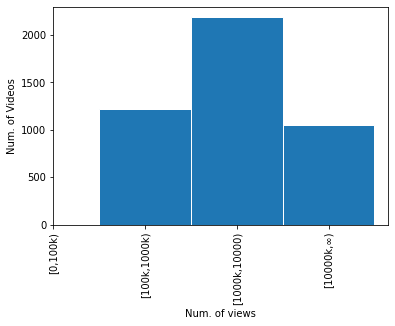

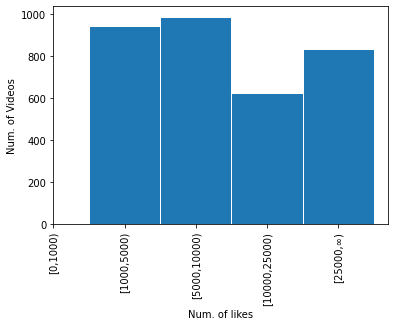

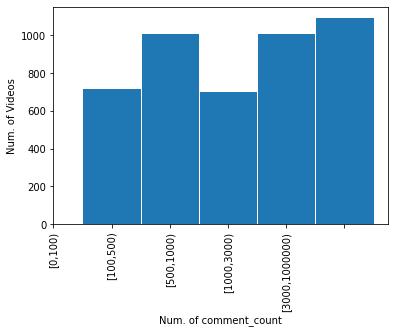

Result (without binning)
                precision    recall  f1-score   support

       [0,100)       0.61      0.67      0.64        72
     [100,500)       0.46      0.36      0.40       116
    [500,1000)       0.19      0.21      0.20        66
   [1000,3000)       0.42      0.44      0.43        95
[3000,1000000)       0.65      0.68      0.67       106

      accuracy                           0.48       455
     macro avg       0.47      0.47      0.47       455
  weighted avg       0.48      0.48      0.48       455

Result (with binning)
                precision    recall  f1-score   support

       [0,100)       0.66      0.79      0.72        72
     [100,500)       0.59      0.65      0.62       116
    [500,1000)       0.36      0.29      0.32        66
   [1000,3000)       0.46      0.44      0.45        95
[3000,1000000)       0.75      0.68      0.71       106

      accuracy                           0.58       455
     macro avg       0.56      0.57      0.56       

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 決定木分析用のクラスをインポート
from sklearn.tree import DecisionTreeClassifier
# データをテスト/学習データに分割するためのクラスをインポート
from sklearn.model_selection import train_test_split
# 再現率、適合率、F値を表示するためにインポート
from sklearn.metrics import classification_report

# データの準備
def prepare():
    !kaggle datasets download -d \
    sgonkaggle/youtube-trend-with-subscriber
    !unzip youtube-trend-with-subscriber.zip

# ビニングして可視化
def binning(df, labels, bins, feature_name):
    plt.figure()
    # digitizeを用いてbinsに指定した範囲に分割
    dg = np.digitize(df[feature_name], bins=bins) 
    # 分割した結果をヒストグラムで可視化
    plt.hist(dg, 
             bins=np.arange(len(bins))+0.5, 
             edgecolor='w')
    plt.xticks(rotation=90)
    plt.ylabel('Num. of Videos')
    plt.xlabel('Num. of {}'.format(feature_name))
    plt.xticks(ticks=list(range(len(bins))), 
               labels=labels)
    plt.savefig('3.4-{}.png'.format(feature_name), dpi=500)
    plt.show()
    return dg
# 学習データとテストデータを作成
def make_train_test_data(dg, sdg, ydg): 
    dg = np.asarray(dg)
    dg = np.reshape(dg,(len(dg),1))
    sdg = np.asarray(sdg)
    sdg = np.reshape(sdg,(len(sdg),1))
    X = np.concatenate([dg, sdg], axis=1) 
    # 9:1の比率で学習データとテストデータに分割
    X_train, X_test, y_train, y_test = \
      train_test_split(X,ydg, 
                      random_state=0,train_size=0.9) 
    return X_train, X_test, y_train, y_test

def main():
    prepare()
    df = pd.read_csv('USvideos_modified.csv')
    # np.digitizeを用いて視聴回数(views)をビニング
    labels = [ '[0,100k)', '[100k,1000k)', 
              '[1000k,10000)', '[10000k,∞)']
    bins = [-1,100000,1000000,10000000]
    dg = binning(df, labels, bins, 'views')
    # np.digitizeを用いてlikesをビニング
    labels = [ '[0,1000)', '[1000,5000)', '[5000,10000)',
              '[10000,25000)', '[25000,∞)']
    bins=[-1,1000,5000,10000,25000]
    sdg = binning(df, labels, bins, 'likes')

    # 視聴回数とlike数をもとにビニングされたコメント数を
    # 予測するモデルを決定木により学習
    # np.digitizeを用いてコメント数(予測対象)をビニングする 
    bins=[-1,100,500,1000,3000,1000000]
    tnames = ['[0,100)', '[100,500)', '[500,1000)', 
              '[1000,3000)', '[3000,1000000)']
    ydg = binning(df, tnames, bins, 'comment_count') 
    # 視聴回数とlikesはビニングしない
    X_train, X_test, y_train, y_test = make_train_test_data(
        df['views'].values, df['likes'].values, ydg)
    dt = DecisionTreeClassifier()
    dt.fit(X_train,y_train)
    y_pred = dt.predict(X_test)
    print('Result (without binning)')
    print(classification_report(y_test, y_pred, 
                                target_names=tnames))
    # コメント数をビニングしたカテゴリを
    # 予測するモデルを決定木によって学習する
    X_train, X_test, y_train, y_test = \
                   make_train_test_data(dg, sdg, ydg)
    
    dt = DecisionTreeClassifier()
    dt.fit(X_train,y_train)
    y_pred = dt.predict(X_test) 
    print('Result (with binning)')
    print(classification_report(y_test, y_pred, 
                                target_names=tnames))

# mainを呼び出すために必要
if __name__ == '__main__':
    main()
